#用户  
cms_segid:微群ID(0-96)  
cms_group_id:广告组群ID(0-12)  

#用户  
final_gender_code:性别（1，2）  
age_level:年龄层次(0,1,2,3,4,5,6)   
pvalue_level:消费档次（1，2，3）  
shopping_level:购物深度（1，2，3）  
occupation:是不是大学生（1，0）  
new_user_class_level:城市层级(0,1,2,3)  

#商品  
cate_id:商品ID(1-12960)  
campaign_id:广告计划ID(13-423434)  
customer:广告商ID(1-225760)  
brand:品牌ID(0-461291)  

#商品  
price:价格  

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc, roc_auc_score
import tensorflow as tf
# from sklearn.metrics import log_loss, roc_auc_score
print(tf.__version__)

# tf.random.set_seed(1)
tf.keras.backend.set_floatx('float64')

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

2.1.0


In [2]:
class CIN_Layer(tf.keras.layers.Layer):
    def __init__(self, in_shape, layerID, **kwargs):
        super(CIN_Layer, self).__init__(**kwargs)
        self.in_shape = in_shape
        self.layerID = layerID
        
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'in_shape': self.in_shape,
            'layerID': self.layerID,
            
        })
        return config
#         'kernel': self.kernel,
#         'add_weight': self.add_weight,
    
    #this is the custom part
    def get3DTensor(self, modelInputs, lastLayerOutput):
        if self.layerID != 0:
            lastLayerOutput = tf.keras.layers.Lambda(tf.split, 
                                                     arguments={'axis':1, 'num_or_size_splits':self.in_shape[0]}, 
                                                     name="split_last_"+str(self.layerID)
                                                    )(lastLayerOutput)
            layerInput = tf.keras.layers.Lambda(tf.split, 
                                                arguments={'axis':1, 'num_or_size_splits':self.in_shape[0]}, 
                                                name="split_last_"+str(self.layerID)
                                               )(modelInputs)
            
        else:
            lastLayerOutput = tf.keras.layers.Lambda(tf.split, 
                                                     arguments={'axis':1, 'num_or_size_splits':self.in_shape[0]}, 
                                                     name="split_last_"+str(self.layerID)
                                                    )(modelInputs)
            layerInput = tf.keras.layers.Lambda(tf.split, 
                                                arguments={'axis':1, 'num_or_size_splits':self.in_shape[0]}, 
                                                name="split_last_"+str(self.layerID)
                                               )(modelInputs)
            
#         print("lastLayerOutput:",len(lastLayerOutput),lastLayerOutput[0])
#         print("input:",layerInput)
        
        chaotic_3DTensor = tf.keras.layers.Lambda(tf.matmul, 
                                                  arguments={'b':layerInput, 'transpose_a':True},
                                                  name="dot_"+str(self.layerID)
                                                 )(lastLayerOutput)
#         print("chaotic_3D:",chaotic_3DTensor.shape)
        
        
        
        _3DTensor = tf.keras.layers.Lambda(tf.transpose, 
                                           arguments={'perm':[1,0,2,3]},
                                           name="transpose_dot_"+str(self.layerID)
                                          )(chaotic_3DTensor)
#         print("_3DTensor:",_3DTensor.shape)
        
        
        squeezedTensor = tf.keras.layers.Lambda(tf.squeeze, 
                                                arguments={'axis':0},
                                                name="squeeze_dot_"+str(self.layerID)
                                               )(_3DTensor)
#         print("squeezedTensor:",squeezedTensor.shape)
        return squeezedTensor

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel'+str(self.layerID), 
                                      shape=[self.in_shape[-1] for i in range(3)],
                                      trainable=True)

    def call(self, inputs, lastLayerOutput=None):
        interaction = self.get3DTensor(inputs, lastLayerOutput)
#         print("here:",interaction.shape, self.kernel.shape,"\n")
        reslut = tf.nn.conv1d(interaction, self.kernel, self.in_shape[1], padding='VALID')
        return tf.transpose(reslut, perm=[1,0,2])

In [3]:
class Autoint_Layer(tf.keras.layers.Layer):
    def __init__(self, in_shape, layerID, head_num, att_embedding_size, use_res=True, **kwargs):
        super(Autoint_Layer, self).__init__(**kwargs)
        self.in_shape = in_shape
        self.layerID = layerID
        self.att_embedding_size = att_embedding_size
        self.head_num = head_num
        self.use_res = use_res
        
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'in_shape': self.in_shape,
            'layerID': self.layerID,
            'att_embedding_size':self.att_embedding_size,
            'head_num':self.head_num,
            'use_res':self.use_res,
            
        })
        return config
    
    #this is the custom part
    def multi_head_self_attention(self, inputs):
        #att_embedding_size为注意力空间下隐向量的长度，head_num为注意力空间的个数，
        #use_res为一个布尔变量，表示是否使用残差连接。
        #首先假设输入inputs的shape为(batch_size,field_size,embedding_size)
        #四个投影矩阵(W_Query,W_Key,W_Value,W_Res)的shape均为(embedding_size, att_embedding_size * head_num)

        #1.通过矩阵乘法得到注意力空间下的三组向量表示
        # (batch_size,field_size,att_embedding_size*head_num)
#         print("Autoint",str(self.layerID)+":",inputs.shape,self.W_Query.shape)
        querys = tf.tensordot(inputs, self.W_Query, axes=(-1, 0))  
        keys = tf.tensordot(inputs, self.W_Key, axes=(-1, 0))
        values = tf.tensordot(inputs, self.W_Value, axes=(-1, 0))
        
        #2.为了同时在不同的子空间下计算特征相似度，需要先进行一些变换
        # (head_num,batch_size,field_size,att_embedding_size)
        querys = tf.stack(tf.split(querys, self.head_num, axis=2))  
        keys = tf.stack(tf.split(keys, self.head_num, axis=2))
        values = tf.stack(tf.split(values, self.head_num, axis=2))
        
        #3.计算相似度及归一化注意力分布
        # (head_num,batch_size,field_size,field_size)
        inner_product = tf.matmul(querys, keys, transpose_b=True) 
        normalized_att_scores = tf.nn.softmax(inner_product)
        
        #4.计算加权和
        # (head_num,batch_size,field_size,att_embedding_size)
        result = tf.matmul(normalized_att_scores, values)
        
        #5.将不同子空间下的结果进行拼接
        result = tf.concat(tf.split(result, self.head_num), axis=-1)
        result = tf.squeeze(result, axis=0)# (batch_size,field_size,att_embedding_size*head_num)
        
        #6.使用残差连接保留原始信息
        if self.use_res:
            result += tf.tensordot(inputs, self.W_Res, axes=(-1, 0))
        # (batch_size,field_size,att_embedding_size*head_num)
        result = tf.matmul(result, self.W_shapeShifter)
#         outputs = tf.nn.relu(result)
        outputs = tf.nn.sigmoid(result)
        return result

    def build(self, input_shape):
        shape = (self.in_shape[1], self.head_num * self.att_embedding_size)
        layerID = self.layerID
#         print("Autoint build",str(self.layerID)+":",shape)
        self.W_Query = self.add_weight(name='W_Query'+str(layerID), shape=shape, trainable=True)
        self.W_Key = self.add_weight(name='W_Key'+str(layerID), shape=shape, trainable=True)
        self.W_Value = self.add_weight(name='W_Value'+str(layerID), shape=shape, trainable=True)
        self.W_Res = self.add_weight(name='W_Res'+str(layerID), shape=shape, trainable=True)
        self.W_shapeShifter = self.add_weight(name='W_shapeShifter'+str(layerID), shape=[self.head_num*self.att_embedding_size,self.in_shape[1]], trainable=True)

    def call(self, inputs):
        interaction = self.multi_head_self_attention(inputs)
#         print("Autoint call:",interaction.shape,"\n")
        return interaction

In [4]:
class XDeepFM():
    def __init__(self, config):
        
#         self.GetDataInfo(config['train_data_file_path'])
#         self.GetDataInfo(config['test_data_file_path'])
        self.GetDataInfo(config['validation_data_file_path'])
        
        self.config = config
        self.config.update({'fields_embeddingSize':config['embeddingSize'] * len(self.fieldInfo)})
        if config['optimizer'] == 'Adam':
            self.optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
        else:
            print("how about use Adam?")
        
        self.model = self.BuildModel(config)
        
    def BuildModel(self, config, showSummary=False):
        '''
        define each part in model, then connect them and build.
        '''
        self.Embedding_model = self.Embedding(self.config['embeddingSize'], self.fieldInfo)
        self.DNN_model = self.DNN(config['fields_embeddingSize'], 
                                  1, 
                                  config['DNN_depth'], 
                                  config['DNN_layer_width'],
                                  name='DNN')
        
        self.CIN_model = self.CIN((len(self.fieldInfo),
                                   config['embeddingSize']),
                                   1,
                                   config['CIN_depth'],
                                   name='CIN')

        self.AutoInt_model = self.AutoInt((len(self.fieldInfo),
                                   config['embeddingSize']),
                                   1,
                                   config['Autoint_depth'],
                                   config['Autoint_head_num'],
                                   config['Autoint_att_embedding_size'],
                                   name='Autoint')
        
        self.Combination_model = self.Combination(self.config['parallel_parts'])
        
        inputs = [tf.keras.Input(shape=(i,)) for i in self.fieldInfo]
#         print("==bulid inputs:\n",inputs)
        
        embeddedData = self.Embedding_model(inputs)
        print('==after embeddedData')
#         print('embeddedDatad:', embeddedData.shape)
        
        DNN_output = self.DNN_model(tf.reshape(embeddedData, [1, len(self.fieldInfo)*config['embeddingSize']]))
        print('==after DNN_output')
        
        CIN_output = self.CIN_model(tf.reshape(embeddedData, [1, len(self.fieldInfo),config['embeddingSize']]))#change it to CIN's shape
        print('==after CIN_output')
        
        AutoInt_output = self.AutoInt_model(tf.reshape(embeddedData, [1, len(self.fieldInfo),config['embeddingSize']]))
        print('==after Autoint_output')
        
        output = self.Combination_model([DNN_output,CIN_output,AutoInt_output])
        print('==after output')
        
        model = tf.keras.Model(inputs=inputs, outputs=output, name='xDeepFM')
        optimizer = tf.keras.optimizers.Adam(lr=self.config['lr'], beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
        model.compile(loss='binary_crossentropy', optimizer=optimizer)#this is the log_loss
        
        if showSummary:
            print("xdeepfm model summary:")
            model.summary()
#             tf.keras.utils.plot_model(model,'model.png',show_shapes=True)
        
        return model
        
    def GetDataInfo(self, path):
        '''
        this function will return infomations of the dataset which provided by the filePath, 
        return it's shape and a dict that holds the features index.

        filePath: a string that holds the path of data

        set:fieldInfo: in the data set, how many features there are
        set:indicesDict: a dictionary that holds all the features in data set, 
                            to help later locate the features location in a tensor
        '''
        print("==GetDataSet:",path)
        data = open(path)
        
        indices = list(data.readline()[:-1].split(","))
        self.indicesDict = [dict() for i in range(len(indices)-2)]#not include label and price
        
        for line in data:
            lineList = line[:-1].split(",")[1:-1]#not include label and price
            for i in range(len(lineList)):
                if lineList[i] not in self.indicesDict[i]:
                    self.indicesDict[i].update({lineList[i]: len(self.indicesDict[i])})
        
        self.fieldInfo = []
        field_I = 0
        for i in range(8):
            field_I += len(self.indicesDict[i])
        self.fieldInfo.append(field_I)
        
        for i in range(8,len(self.indicesDict)):
            self.fieldInfo.append(len(self.indicesDict[i]))
        self.fieldInfo.append(1)
        print("fieldInfo:",self.fieldInfo)
    
    def Multi_hot_encode_batch(self, batch):
        labels = []
        featuresMatrix = []
        
        for index,line in batch.iterrows():
            features, label = self.Multi_hot_encode(line)
            
            featuresMatrix.append(features)
            labels.append(label)
            
        return featuresMatrix, np.array(labels)
    
    def Multi_hot_encode(self, line):
        
        def customTanh(x):
            return np.tanh(float(x) * self.config['priceNormalizeCoefficient'])
        
        lineList = list(line.values)[1:]
        label = float(line['label'])
        if label > 1:
            print(lineList)
            print(label)
            return
        
        tensorOfFields = []
        fieldsCombination = []
        
        for i in range(8):
            field = np.zeros([1,len(self.indicesDict[i])])
            if i in [4,7]:
                field[0][self.indicesDict[i][str(lineList[i])]] = 1
            else:
                field[0][self.indicesDict[i][str(int(lineList[i]))]] = 1
            
            fieldsCombination.append(field)
        tensorOfFields.append(np.hstack(fieldsCombination))
        
        for i in range(8,len(lineList)-1):
            field = np.zeros([1,len(self.indicesDict[i])])
#             print(self.indicesDict[i].keys())
#             print(field.shape, lineList[i])
            if i in [4,7,11]:
                field[0][self.indicesDict[i][str(lineList[i])]] = 1
            else:
                field[0][self.indicesDict[i][str(int(lineList[i]))]] = 1
            tensorOfFields.append(field)
        
        tensorOfFields.append(np.array([customTanh(lineList[-1])]))
        
        return tensorOfFields, np.array([label]) 

    def Embedding(self, embeddingSize, dataInfo, showSummary=False):
        '''
        embeddingSize: what size(length) to compress each input fields to. Should be an int
        dataInfo: about each the fields, what is it's length. Should be a list

        build the embedding part model
        '''
        def fieldEmbedding(in_shape, out_shape, name=None):
            inputs = tf.keras.Input(shape=(in_shape,))
            outputs = tf.keras.layers.Dense(out_shape,trainable=True)(inputs)
#             outputs = tf.keras.layers.Dense(out_shape)(inputs)
            return tf.keras.Model(inputs, outputs, name=name)
        
        embeddingModel = []
        inputs = []
        outputs = []

        #1.prepare embedding parts for each field
        for i in range(len(dataInfo)):
            print("field[{0}] length: {1}".format(i,dataInfo[i]))
            embeddingModel.append(fieldEmbedding(dataInfo[i], embeddingSize, name='embeddingField'+str(i)))
            inputs.append(tf.keras.Input(shape=(dataInfo[i],),name='field'+str(i)))

        #2.connect all embedding parts for fields
        for model,i in zip(embeddingModel, inputs):
            #print("1:",model,"-end1\n","2:",i,"-end2")
            outputs.append(model(i))
            #print("3:",type(outputs[-1]),"-end3\n")
        output = tf.concat(outputs, axis=1)

        concat = tf.keras.Model(inputs=inputs, outputs=output, name='Embedding_model')

        #3.compile model
        optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
        concat.compile(loss='binary_crossentropy', optimizer=optimizer)

        if showSummary:
            print("Embedding summary:")
            concat.summary()
            
        return concat
    
    def DNN(self, in_shape, out_shape, depth, layerWidth, name='DNN_model', activeFunc='relu', showSummary=False):
        
        inputs = tf.keras.Input(shape=(in_shape,))
        outputs = tf.keras.layers.Dense(layerWidth, use_bias=True, activation=activeFunc)(inputs)
        for i in range(depth - 1):
            outputs = tf.keras.layers.Dense(layerWidth, activation=activeFunc, use_bias=True)(outputs)

        outputs = tf.keras.layers.Dense(out_shape, use_bias=True, activation='softmax')(outputs)

        model = tf.keras.Model(inputs, outputs, name=name)
        optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
        model.compile(loss='binary_crossentropy', optimizer=optimizer)
        if showSummary:
            print("DNN summary:")
            model.summary()
    
        return model
    
    def CIN(self, in_shape, out_shape, depth, name='CIN_model', activeFunc='softmax', showSummary=False):
        CINLayers = [CIN_Layer(in_shape=in_shape, layerID=d) for d in range(depth)]

        inputs = tf.keras.layers.Input(shape=in_shape)
        lastLayerOutput = CINLayers[0](inputs, None) 
        for i in range(1,len(CINLayers)):
            lastLayerOutput = CINLayers[i](inputs, lastLayerOutput)
            
        flattenOutput = tf.keras.layers.Flatten(name='CIN_flatten')(lastLayerOutput)
        output = tf.keras.layers.Dense(1)(flattenOutput)
        
        model = tf.keras.Model(inputs=inputs, outputs=output, name=name)  
        model.compile(loss='binary_crossentropy', optimizer='ADAM')  
        
        if showSummary:
            model.summary()
        return model
    
    def AutoInt(self, in_shape, out_shape, depth, head_num, att_embedding_size, name='Autoint_model', showSummary=True):
        AutointLayers = []
        for i in range(depth):
            AutointLayer = Autoint_Layer(in_shape=in_shape, layerID=i, head_num=head_num, att_embedding_size=att_embedding_size)
            AutointLayers.append(AutointLayer)

        inputs = tf.keras.layers.Input(shape=in_shape)
        lastLayerOutput = AutointLayers[0](inputs)
        for l in range(1,len(AutointLayers)):
            lastLayerOutput = AutointLayers[l](lastLayerOutput)

        flattenOutput = tf.keras.layers.Flatten(name='Autoint_flatten')(lastLayerOutput)
        output = tf.keras.layers.Dense(1)(flattenOutput)

        model = tf.keras.Model(inputs=inputs, outputs=output)  
        model.compile(loss='binary_crossentropy', optimizer='ADAM')
        return model
    
    def Combination(self, in_shape, showSummary=False):
        inputs = [tf.keras.Input(shape=(1,)) for i in range(in_shape)]
            
        concat = tf.concat(inputs, axis=1)
        outputs = tf.keras.layers.Dense(1, activation='sigmoid')(concat)
        
        model = tf.keras.Model(inputs=inputs, outputs=outputs, name='Combination_model')
        model.compile(loss=self.config['loss'], optimizer=self.optimizer)
        
        if showSummary:
            print("Combination summary:")
            model.summary()
    
        return model
    
    def train(self, saveModel=False, drawLossChange=True):
        loss_history = []
        
        exceptionCount = 0
        trainningCount = 0
        
        data = pd.read_csv(self.config['train_data_file_path'])
        
        for e in range(self.config['epoch']):
            print("=================================================================================\nEpoch %d" % e)
            
            batch = data.sample(frac=self.config['batchRatio'])
            features, labels = self.Multi_hot_encode_batch(batch)
            
            for f, l in zip(features, labels):
#                 print("HERE:",[a.shape for a in f], l)
                history = self.model.fit(f, l)
                
                trainningCount += 1
                if history.history['loss'][0] > 1.0:
                    exceptionCount += 1
                    continue
                loss_history.append(history.history['loss'])
        
        if saveModel:
            self.saveModel()
        
        print("==exceptionCount:",exceptionCount)
        print("==trainningCount:",trainningCount)
        print("==exception ratio:",exceptionCount/trainningCount)
        if drawLossChange:
            plt.plot(loss_history, 'r', label='loss_history')
            plt.legend(['training loss changing'], loc='upper left')
            
            plt.show()
    
    def evaluate(self, path="", savePlotPict=False):
        '''
        using log_loss to evaluate the model, which means it only needs the CTR(predict possibility)
        but using the model to make a binary-classfication, the model needs a specific threshold value....which I haven't wrote yet
        '''
        print(path)
        def __log_loss(label, prediction):
            if label in [0.0, 0, "0", "0.0"]:
                return -1*np.log(1-prediction)
            if label in [1.0, 1, "1", "1.0"]:
                return -1*label * np.log(prediction)
            
            print("==================fucking label:",label)
            
            return -1
        
        #because of the damn data structre of model inputs, the traditrional evaluate methord is not able to do it.
        if path == "":
            path = self.config['test_data_file_path']
        evaluateData = pd.read_csv(path).sample(frac=0.5)
        features, labels = self.Multi_hot_encode_batch(evaluateData)

        predictions = []
        lossList = []
        labelList = []
        
        for f,l in zip(features, labels):
            prediction = self.model.predict(f, batch_size=1)
            
            loss = __log_loss(l[0], prediction[0][0])
            
            lossList.append(loss)
            labelList.append(l[0])
            predictions.append(prediction[0][0])
            
            print("prediction:", round(prediction[0][0],4))
            print("  log_loss:", round(loss,4))
            print("     label:", l[0])
            print("==========")
        
        print("==logloss:",lossList)
        print("==logloss error:", round(sum(lossList) / len(lossList), 4))
        print("==AUC:", round(roc_auc_score(labelList, predictions),4))
        
        #draw a picture to show ROC
        fpr,tpr,threshold = roc_curve(labelList, predictions) ###计算真正率和假正率
#         print("lossList:",lossList)
        print(" fpr:",fpr,"\n tpr:",tpr, "\n threshold:",threshold)
        roc_auc = auc(fpr,tpr) ###计算auc的值
        
#         if roc_auc > 0.808 or roc_auc < 0.795:
#             return False
            
        plt.figure()
        lw = 2
        plt.figure(figsize=(10,10))
        plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        ###假正率为横坐标，真正率为纵坐标做曲线
        
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        
        if savePlotPict:
            fig, ax = plt.subplots()
            fig.savefig('ROC.eps',dpi=1200)
        
        plt.show()
#         return True
    
    def saveModel(self, modelName="xdeepfm.h5"):
        path = "./"
        if self.config['saveModelPath']:
            path = self.config['saveModelPath'] + modelName
        else:
            path += modelName
            
        print("==Saving model to:", path)
        self.model.save(path)

==GetDataSet: ./real_ctr_data/ctr_validation.csv
fieldInfo: [102, 561, 968, 962, 749, 1]
field[0] length: 102
field[1] length: 561
field[2] length: 968
field[3] length: 962
field[4] length: 749
field[5] length: 1
==after embeddedData
embeddedDatad: (None, 660)
==after DNN_output
==after CIN_output
==after Autoint_output
==after output
Epoch 0
Train on 1 samples
1/1 [==============================] - 2s 2s/sample - loss: 0.9228
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.9212
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.9214
Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.9217
Train on 1 samples
1/1 [==============================] - 0s 119ms/sample - loss: 0.9199
Train on 1 samples
1/1 [==============================] - 0s 119ms/sample - loss: 0.9210
Train on 1 samples
1/1 [==============================] - 0s 119ms/sample - loss: 0.5081
Train on 1 samples
1/1 [===========

Train on 1 samples
1/1 [==============================] - 0s 119ms/sample - loss: 0.7106
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.8203
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.4435
Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 0.7850
Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 0.6660
Train on 1 samples
1/1 [==============================] - 0s 109ms/sample - loss: 0.8072
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.5654
Train on 1 samples
1/1 [==============================] - 0s 120ms/sample - loss: 0.5769
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.6816
Train on 1 samples
1/1 [==============================] - 0s 109ms/sample - loss: 0.6629
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.7826
Train on 1 samples
1/

Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.6240
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.3699
Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 0.3138
Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.0193
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.0052
Train on 1 samples
1/1 [==============================] - 0s 120ms/sample - loss: 0.3621
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.1137
Train on 1 samples
1/1 [==============================] - 0s 107ms/sample - loss: 0.3252
Train on 1 samples
1/1 [==============================] - 0s 378ms/sample - loss: 0.1004
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.0589
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.0121
Train on 1 samples
1/

1/1 [==============================] - 0s 114ms/sample - loss: 0.3189
Train on 1 samples
1/1 [==============================] - 0s 109ms/sample - loss: 0.5085
Train on 1 samples
1/1 [==============================] - 0s 106ms/sample - loss: 0.1457
Train on 1 samples
1/1 [==============================] - 0s 108ms/sample - loss: 1.1281
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.3656
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.0686
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.0831
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.3148
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.0945
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.1573
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.1524
Train on 1 samples
1/1 [================

Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 0.0225
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.0762
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.0827
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.1381
Train on 1 samples
1/1 [==============================] - 0s 121ms/sample - loss: 0.0309
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.0370
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.2930
Train on 1 samples
1/1 [==============================] - 0s 107ms/sample - loss: 0.0318
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.1403
Train on 1 samples
1/1 [==============================] - 0s 109ms/sample - loss: 0.0031
Train on 1 samples
1/1 [==============================] - 0s 105ms/sample - loss: 0.1071
Train on 1 samples
1/

Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.0959
Train on 1 samples
1/1 [==============================] - 0s 120ms/sample - loss: 0.0440
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.0065
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.0305
Train on 1 samples
1/1 [==============================] - 0s 120ms/sample - loss: 0.0240
Train on 1 samples
1/1 [==============================] - 0s 108ms/sample - loss: 0.2889
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.2267
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 2.9908
Train on 1 samples
1/1 [==============================] - 0s 106ms/sample - loss: 0.1320
Train on 1 samples
1/1 [==============================] - 0s 108ms/sample - loss: 0.0393
Train on 1 samples
1/1 [==============================] - 0s 108ms/sample - loss: 0.1930
Train on 1 samples
1/

1/1 [==============================] - 0s 115ms/sample - loss: 0.1944
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.1250
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.0272
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.2473
Train on 1 samples
1/1 [==============================] - 0s 109ms/sample - loss: 0.0330
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.1597
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.0299
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.0659
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.0549
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 2.2445
Train on 1 samples
1/1 [==============================] - 0s 107ms/sample - loss: 0.2038
Train on 1 samples
1/1 [================

Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 0.3637
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.2943
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.1687
Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 0.0151
Train on 1 samples
1/1 [==============================] - 0s 109ms/sample - loss: 0.2787
Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 0.1598
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.1332
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.3361
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.2317
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.1593
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.1573
Train on 1 samples
1/

1/1 [==============================] - 0s 108ms/sample - loss: 0.1687
Train on 1 samples
1/1 [==============================] - 0s 108ms/sample - loss: 0.1548
Train on 1 samples
1/1 [==============================] - 0s 107ms/sample - loss: 0.0758
Train on 1 samples
1/1 [==============================] - 0s 109ms/sample - loss: 0.0101
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.1173
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.0438
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.0505
Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 0.2225
Train on 1 samples
1/1 [==============================] - 0s 106ms/sample - loss: 0.0715
Train on 1 samples
1/1 [==============================] - 0s 119ms/sample - loss: 0.0428
Train on 1 samples
1/1 [==============================] - 0s 119ms/sample - loss: 0.0710
Train on 1 samples
1/1 [================

Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.0432
Train on 1 samples
1/1 [==============================] - 0s 108ms/sample - loss: 2.6379
Train on 1 samples
1/1 [==============================] - 0s 107ms/sample - loss: 0.0019
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.0111
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.1307
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.1012
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.0314
Train on 1 samples
1/1 [==============================] - 0s 119ms/sample - loss: 0.0206
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.0179
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.0355
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 2.9381
Train on 1 samples
1/

1/1 [==============================] - 0s 111ms/sample - loss: 1.5669
Train on 1 samples
1/1 [==============================] - 0s 109ms/sample - loss: 0.1481
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.1086
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.1116
Train on 1 samples
1/1 [==============================] - 0s 107ms/sample - loss: 0.1222
Train on 1 samples
1/1 [==============================] - 0s 109ms/sample - loss: 0.1516
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.0144
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.2282
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 2.1966
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.0144
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.1686
Train on 1 samples
1/1 [================

Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.2501
Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.0608
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.1711
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.0635
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 1.9558
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.1279
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.2135
Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.1727
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.0766
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.2042
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.2210
Train on 1 samples
1/

1/1 [==============================] - 0s 124ms/sample - loss: 2.9306
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.0934
Train on 1 samples
1/1 [==============================] - 0s 120ms/sample - loss: 0.0849
Train on 1 samples
1/1 [==============================] - 0s 108ms/sample - loss: 0.0684
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.1047
Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.0382
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.0341
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.0631
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.0614
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.0573
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.1732
Train on 1 samples
1/1 [================

Train on 1 samples
1/1 [==============================] - 0s 109ms/sample - loss: 0.1527
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 2.0727
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.2323
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.1244
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.1435
Train on 1 samples
1/1 [==============================] - 0s 106ms/sample - loss: 0.2232
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.1812
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 1.8777
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.1469
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.1721
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 1.6568
Train on 1 samples
1/

1/1 [==============================] - 0s 111ms/sample - loss: 0.0539
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 2.5427
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.0696
Train on 1 samples
1/1 [==============================] - 0s 106ms/sample - loss: 0.0867
Train on 1 samples
1/1 [==============================] - 0s 109ms/sample - loss: 0.0975
Train on 1 samples
1/1 [==============================] - 0s 107ms/sample - loss: 0.1612
Train on 1 samples
1/1 [==============================] - 0s 119ms/sample - loss: 0.1370
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.0961
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.0854
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.1486
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.0845
Train on 1 samples
1/1 [================

Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.0698
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.0638
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.0541
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.1230
Train on 1 samples
1/1 [==============================] - 0s 107ms/sample - loss: 2.5782
Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 0.0658
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.0605
Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 0.1139
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.1084
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.1743
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.0735
Train on 1 samples
1/

1/1 [==============================] - 0s 111ms/sample - loss: 2.6202
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.1092
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 3.3810
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.0664
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.0488
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.0885
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.0585
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.0784
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.0995
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.0531
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.0688
Train on 1 samples
1/1 [================

Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.0658
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.0984
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.0658
Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.0766
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.0756
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.0808
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.1108
Train on 1 samples
1/1 [==============================] - 0s 109ms/sample - loss: 0.0694
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 2.8245
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.0966
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.1123
Train on 1 samples
1/

1/1 [==============================] - 0s 112ms/sample - loss: 0.0825
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.0514
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 3.0816
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.0488
Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 2.7039
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.0813
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.1079
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.0915
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.0839
Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 0.0759
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.0634
Train on 1 samples
1/1 [================

Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 0.0663
Train on 1 samples
1/1 [==============================] - 0s 120ms/sample - loss: 0.1296
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.1170
Train on 1 samples
1/1 [==============================] - 0s 108ms/sample - loss: 0.1064
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 2.0449
Train on 1 samples
1/1 [==============================] - 0s 106ms/sample - loss: 0.0365
Train on 1 samples
1/1 [==============================] - 0s 107ms/sample - loss: 0.0534
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 2.7723
Train on 1 samples
1/1 [==============================] - 0s 108ms/sample - loss: 0.1066
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.0558
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 3.2852
Train on 1 samples
1/

1/1 [==============================] - 0s 116ms/sample - loss: 0.0358
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 2.5727
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.0302
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.0599
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.0426
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.0839
Train on 1 samples
1/1 [==============================] - 0s 109ms/sample - loss: 0.0307
Train on 1 samples
1/1 [==============================] - 0s 109ms/sample - loss: 0.0449
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.0852
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 2.9595
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.0431
Train on 1 samples
1/1 [================

Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.0458
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.0615
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.0825
Train on 1 samples
1/1 [==============================] - 0s 109ms/sample - loss: 0.0462
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.0367
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.0484
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.0833
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.0731
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.1326
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.0424
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.0667
Train on 1 samples
1/

1/1 [==============================] - 0s 110ms/sample - loss: 0.0283
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.0210
Train on 1 samples
1/1 [==============================] - 0s 121ms/sample - loss: 0.0686
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.0749
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.0539
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.0527
Train on 1 samples
1/1 [==============================] - 0s 108ms/sample - loss: 0.0510
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.0964
Train on 1 samples
1/1 [==============================] - 0s 109ms/sample - loss: 0.0323
Train on 1 samples
1/1 [==============================] - 0s 109ms/sample - loss: 0.0488
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 2.5333
Train on 1 samples
1/1 [================

Train on 1 samples
1/1 [==============================] - 0s 109ms/sample - loss: 0.1609
Train on 1 samples
1/1 [==============================] - 0s 109ms/sample - loss: 0.1245
Train on 1 samples
1/1 [==============================] - 0s 127ms/sample - loss: 0.1207
Train on 1 samples
1/1 [==============================] - 0s 132ms/sample - loss: 0.0561
Train on 1 samples
1/1 [==============================] - 0s 124ms/sample - loss: 0.1634
Train on 1 samples
1/1 [==============================] - 0s 122ms/sample - loss: 0.0931
Train on 1 samples
1/1 [==============================] - 0s 123ms/sample - loss: 0.1415
Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.0967
Train on 1 samples
1/1 [==============================] - 0s 127ms/sample - loss: 0.1301
Train on 1 samples
1/1 [==============================] - 0s 119ms/sample - loss: 0.0611
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.1077
Train on 1 samples
1/

1/1 [==============================] - 0s 129ms/sample - loss: 0.1105
Train on 1 samples
1/1 [==============================] - 0s 130ms/sample - loss: 0.0796
Train on 1 samples
1/1 [==============================] - 0s 134ms/sample - loss: 0.1138
Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.0417
Train on 1 samples
1/1 [==============================] - 0s 125ms/sample - loss: 0.0264
Train on 1 samples
1/1 [==============================] - 0s 121ms/sample - loss: 0.0983
Train on 1 samples
1/1 [==============================] - 0s 127ms/sample - loss: 0.0565
Train on 1 samples
1/1 [==============================] - 0s 148ms/sample - loss: 0.0997
Train on 1 samples
1/1 [==============================] - 0s 122ms/sample - loss: 0.0102
Train on 1 samples
1/1 [==============================] - 0s 137ms/sample - loss: 0.0584
Train on 1 samples
1/1 [==============================] - 0s 129ms/sample - loss: 0.1567
Train on 1 samples
1/1 [================

Train on 1 samples
1/1 [==============================] - 0s 131ms/sample - loss: 0.1719
Train on 1 samples
1/1 [==============================] - 0s 130ms/sample - loss: 0.2256
Train on 1 samples
1/1 [==============================] - 0s 130ms/sample - loss: 0.1926
Train on 1 samples
1/1 [==============================] - 0s 129ms/sample - loss: 0.2369
Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 0.1837
Train on 1 samples
1/1 [==============================] - 0s 126ms/sample - loss: 0.2482
Train on 1 samples
1/1 [==============================] - 0s 122ms/sample - loss: 0.1795
Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.1106
Train on 1 samples
1/1 [==============================] - 0s 155ms/sample - loss: 0.1526
Train on 1 samples
1/1 [==============================] - 0s 124ms/sample - loss: 0.1840
Train on 1 samples
1/1 [==============================] - 0s 121ms/sample - loss: 0.2445
Train on 1 samples
1/

1/1 [==============================] - 0s 124ms/sample - loss: 0.1416
Train on 1 samples
1/1 [==============================] - 0s 120ms/sample - loss: 0.0908
Train on 1 samples
1/1 [==============================] - 0s 123ms/sample - loss: 0.1534
Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.1052
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.0423
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.0585
Train on 1 samples
1/1 [==============================] - 0s 119ms/sample - loss: 0.0919
Train on 1 samples
1/1 [==============================] - 0s 120ms/sample - loss: 0.1291
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.1774
Train on 1 samples
1/1 [==============================] - 0s 122ms/sample - loss: 0.1185
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.0810
Train on 1 samples
1/1 [================

Train on 1 samples
1/1 [==============================] - 0s 126ms/sample - loss: 0.1938
Train on 1 samples
1/1 [==============================] - 0s 100ms/sample - loss: 0.1274
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 2.2668
Train on 1 samples
1/1 [==============================] - 0s 119ms/sample - loss: 0.0627
Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 0.1604
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.1724
Train on 1 samples
1/1 [==============================] - 0s 119ms/sample - loss: 0.0939
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.1878
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.1407
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.1169
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.1292
Train on 1 samples
1/

1/1 [==============================] - 0s 115ms/sample - loss: 0.1197
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.0786
Train on 1 samples
1/1 [==============================] - 0s 122ms/sample - loss: 0.1063
Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 0.0652
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.0855
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.0535
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.0379
Train on 1 samples
1/1 [==============================] - 0s 123ms/sample - loss: 0.0785
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 2.3674
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.0654
Train on 1 samples
1/1 [==============================] - 0s 119ms/sample - loss: 0.0983
Train on 1 samples
1/1 [================

Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.0962
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 2.8104
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.1041
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.0222
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.0695
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.0871
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.1242
Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 0.1131
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.1148
Train on 1 samples
1/1 [==============================] - 0s 127ms/sample - loss: 0.0382
Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.0894
Train on 1 samples
1/

1/1 [==============================] - 0s 118ms/sample - loss: 2.1218
Train on 1 samples
1/1 [==============================] - 0s 122ms/sample - loss: 0.1150
Train on 1 samples
1/1 [==============================] - 0s 133ms/sample - loss: 0.0286
Train on 1 samples
1/1 [==============================] - 0s 121ms/sample - loss: 0.0635
Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.0782
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.0439
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.0215
Train on 1 samples
1/1 [==============================] - 0s 120ms/sample - loss: 0.1191
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.0522
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.0590
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.0724
Train on 1 samples
1/1 [================

Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.1347
Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 0.0528
Train on 1 samples
1/1 [==============================] - 0s 128ms/sample - loss: 0.0561
Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.0594
Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.1420
Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.0502
Train on 1 samples
1/1 [==============================] - 0s 120ms/sample - loss: 0.0328
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 3.0559
Train on 1 samples
1/1 [==============================] - 0s 122ms/sample - loss: 0.0783
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.0637
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.0175
Train on 1 samples
1/

1/1 [==============================] - 0s 114ms/sample - loss: 0.0691
Train on 1 samples
1/1 [==============================] - 0s 121ms/sample - loss: 0.0911
Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 0.0775
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.0747
Train on 1 samples
1/1 [==============================] - 0s 119ms/sample - loss: 0.0554
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.0135
Train on 1 samples
1/1 [==============================] - 0s 124ms/sample - loss: 0.1497
Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.0654
Train on 1 samples
1/1 [==============================] - 0s 126ms/sample - loss: 0.0397
Train on 1 samples
1/1 [==============================] - 0s 315ms/sample - loss: 0.0554
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.1594
Train on 1 samples
1/1 [================

Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.0461
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.1660
Train on 1 samples
1/1 [==============================] - 0s 123ms/sample - loss: 0.0130
Train on 1 samples
1/1 [==============================] - 0s 121ms/sample - loss: 0.0845
Train on 1 samples
1/1 [==============================] - 0s 120ms/sample - loss: 0.0871
Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.0147
Train on 1 samples
1/1 [==============================] - 0s 122ms/sample - loss: 0.1249
Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.1115
Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 0.1149
Train on 1 samples
1/1 [==============================] - 0s 120ms/sample - loss: 0.1015
Train on 1 samples
1/1 [==============================] - 0s 129ms/sample - loss: 0.0152
Train on 1 samples
1/

1/1 [==============================] - 0s 119ms/sample - loss: 2.8798
Train on 1 samples
1/1 [==============================] - 0s 121ms/sample - loss: 0.1248
Train on 1 samples
1/1 [==============================] - 0s 119ms/sample - loss: 0.0886
Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 0.0396
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.0966
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.0768
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.1348
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.0744
Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.0359
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.0076
Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.0108
Train on 1 samples
1/1 [================

Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.0270
Train on 1 samples
1/1 [==============================] - 0s 129ms/sample - loss: 0.1367
Train on 1 samples
1/1 [==============================] - 0s 129ms/sample - loss: 0.0647
Train on 1 samples
1/1 [==============================] - 0s 121ms/sample - loss: 0.0660
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.1069
Train on 1 samples
1/1 [==============================] - 0s 122ms/sample - loss: 0.1898
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.0762
Train on 1 samples
1/1 [==============================] - 0s 119ms/sample - loss: 1.8600
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.0731
Train on 1 samples
1/1 [==============================] - 0s 121ms/sample - loss: 0.1622
Train on 1 samples
1/1 [==============================] - 0s 119ms/sample - loss: 0.0711
Train on 1 samples
1/

1/1 [==============================] - 0s 116ms/sample - loss: 0.1218
Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 0.1155
Train on 1 samples
1/1 [==============================] - 0s 122ms/sample - loss: 0.1896
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.1364
Train on 1 samples
1/1 [==============================] - 0s 120ms/sample - loss: 0.1042
Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 0.0969
Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.1039
Train on 1 samples
1/1 [==============================] - 0s 123ms/sample - loss: 0.1344
Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.1193
Train on 1 samples
1/1 [==============================] - 0s 122ms/sample - loss: 0.1080
Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.0977
Train on 1 samples
1/1 [================

Train on 1 samples
1/1 [==============================] - 0s 119ms/sample - loss: 0.0660
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 2.4427
Train on 1 samples
1/1 [==============================] - 0s 119ms/sample - loss: 0.0340
Train on 1 samples
1/1 [==============================] - 0s 123ms/sample - loss: 0.0631
Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.0537
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.0509
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.0423
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 2.3583
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 2.4513
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.0836
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.0358
Train on 1 samples
1/

1/1 [==============================] - 0s 121ms/sample - loss: 0.0942
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 1.9622
Train on 1 samples
1/1 [==============================] - 0s 127ms/sample - loss: 0.0726
Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.1049
Train on 1 samples
1/1 [==============================] - 0s 125ms/sample - loss: 0.0794
Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 0.1074
Train on 1 samples
1/1 [==============================] - 0s 123ms/sample - loss: 1.9447
Train on 1 samples
1/1 [==============================] - 0s 120ms/sample - loss: 0.0452
Train on 1 samples
1/1 [==============================] - 0s 121ms/sample - loss: 0.1039
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.1348
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 2.0078
Train on 1 samples
1/1 [================

Train on 1 samples
1/1 [==============================] - 0s 122ms/sample - loss: 0.2142
Train on 1 samples
1/1 [==============================] - 0s 122ms/sample - loss: 0.1098
Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 0.0797
Train on 1 samples
1/1 [==============================] - 0s 123ms/sample - loss: 0.1169
Train on 1 samples
1/1 [==============================] - 0s 122ms/sample - loss: 0.0736
Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 0.0523
Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.0615
Train on 1 samples
1/1 [==============================] - 0s 119ms/sample - loss: 0.0552
Train on 1 samples
1/1 [==============================] - 0s 121ms/sample - loss: 0.1850
Train on 1 samples
1/1 [==============================] - 0s 119ms/sample - loss: 0.0784
Train on 1 samples
1/1 [==============================] - 0s 120ms/sample - loss: 0.1703
Train on 1 samples
1/

1/1 [==============================] - 0s 108ms/sample - loss: 0.0943
Train on 1 samples
1/1 [==============================] - 0s 105ms/sample - loss: 0.0335
Train on 1 samples
1/1 [==============================] - 0s 108ms/sample - loss: 0.0384
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.1259
Train on 1 samples
1/1 [==============================] - 0s 107ms/sample - loss: 0.0790
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.0539
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.2358
Train on 1 samples
1/1 [==============================] - 0s 109ms/sample - loss: 0.0997
Train on 1 samples
1/1 [==============================] - 0s 105ms/sample - loss: 0.1426
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.1101
Train on 1 samples
1/1 [==============================] - 0s 106ms/sample - loss: 0.0704
Train on 1 samples
1/1 [================

Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.0417
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.0371
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.0621
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.0537
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.1698
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.0210
Train on 1 samples
1/1 [==============================] - 0s 105ms/sample - loss: 2.6957
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 2.5849
Train on 1 samples
1/1 [==============================] - 0s 104ms/sample - loss: 0.0555
Train on 1 samples
1/1 [==============================] - 0s 107ms/sample - loss: 0.0149
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.1214
Train on 1 samples
1/

1/1 [==============================] - 0s 104ms/sample - loss: 0.0722
Train on 1 samples
1/1 [==============================] - 0s 107ms/sample - loss: 0.0956
Train on 1 samples
1/1 [==============================] - 0s 106ms/sample - loss: 0.0319
Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 0.1245
Train on 1 samples
1/1 [==============================] - 0s 107ms/sample - loss: 0.0723
Train on 1 samples
1/1 [==============================] - 0s 105ms/sample - loss: 0.0763
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.0018
Train on 1 samples
1/1 [==============================] - 0s 108ms/sample - loss: 0.0306
Train on 1 samples
1/1 [==============================] - 0s 104ms/sample - loss: 0.0602
Train on 1 samples
1/1 [==============================] - 0s 108ms/sample - loss: 0.0338
Train on 1 samples
1/1 [==============================] - 0s 107ms/sample - loss: 0.0808
Train on 1 samples
1/1 [================

Train on 1 samples
1/1 [==============================] - 0s 106ms/sample - loss: 0.0497
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.0108
Train on 1 samples
1/1 [==============================] - 0s 106ms/sample - loss: 0.1228
Train on 1 samples
1/1 [==============================] - 0s 104ms/sample - loss: 0.0325
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.0207
Epoch 6
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.0213
Train on 1 samples
1/1 [==============================] - 0s 105ms/sample - loss: 0.1171
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.0335
Train on 1 samples
1/1 [==============================] - 0s 106ms/sample - loss: 0.0600
Train on 1 samples
1/1 [==============================] - 0s 108ms/sample - loss: 2.7297
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.0174
Train on 1 sa

1/1 [==============================] - 0s 114ms/sample - loss: 0.0193
Train on 1 samples
1/1 [==============================] - 0s 107ms/sample - loss: 0.0228
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.0587
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.0895
Train on 1 samples
1/1 [==============================] - 0s 108ms/sample - loss: 0.0155
Train on 1 samples
1/1 [==============================] - 0s 103ms/sample - loss: 0.0459
Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 0.1101
Train on 1 samples
1/1 [==============================] - 0s 101ms/sample - loss: 0.0252
Train on 1 samples
1/1 [==============================] - 0s 108ms/sample - loss: 0.1612
Train on 1 samples
1/1 [==============================] - 0s 107ms/sample - loss: 0.1049
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.0834
Train on 1 samples
1/1 [================

Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.0477
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.0650
Train on 1 samples
1/1 [==============================] - 0s 109ms/sample - loss: 0.0836
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.0994
Train on 1 samples
1/1 [==============================] - 0s 106ms/sample - loss: 0.0210
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.0459
Train on 1 samples
1/1 [==============================] - 0s 106ms/sample - loss: 0.0522
Train on 1 samples
1/1 [==============================] - 0s 106ms/sample - loss: 0.0476
Train on 1 samples
1/1 [==============================] - 0s 106ms/sample - loss: 0.1707
Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 0.0941
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 1.9506
Train on 1 samples
1/

1/1 [==============================] - 0s 106ms/sample - loss: 0.0581
Train on 1 samples
1/1 [==============================] - 0s 109ms/sample - loss: 0.0564
Train on 1 samples
1/1 [==============================] - 0s 107ms/sample - loss: 0.0919
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.0179
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.2478
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.0899
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.0435
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.0835
Train on 1 samples
1/1 [==============================] - 0s 106ms/sample - loss: 0.0355
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.1203
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.1311
Train on 1 samples
1/1 [================

Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.0255
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.1419
Train on 1 samples
1/1 [==============================] - 0s 108ms/sample - loss: 0.0505
Train on 1 samples
1/1 [==============================] - 0s 105ms/sample - loss: 1.7429
Train on 1 samples
1/1 [==============================] - 0s 108ms/sample - loss: 0.0689
Train on 1 samples
1/1 [==============================] - 0s 109ms/sample - loss: 0.1157
Train on 1 samples
1/1 [==============================] - 0s 107ms/sample - loss: 0.0623
Train on 1 samples
1/1 [==============================] - 0s 104ms/sample - loss: 0.0259
Train on 1 samples
1/1 [==============================] - 0s 108ms/sample - loss: 0.1481
Train on 1 samples
1/1 [==============================] - 0s 105ms/sample - loss: 0.1101
Train on 1 samples
1/1 [==============================] - 0s 107ms/sample - loss: 0.1434
Train on 1 samples
1/

1/1 [==============================] - 0s 121ms/sample - loss: 0.0314
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.0823
Train on 1 samples
1/1 [==============================] - 0s 136ms/sample - loss: 3.1381
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.0281
Train on 1 samples
1/1 [==============================] - 0s 125ms/sample - loss: 0.1102
Train on 1 samples
1/1 [==============================] - 0s 126ms/sample - loss: 0.0572
Train on 1 samples
1/1 [==============================] - 0s 119ms/sample - loss: 0.1604
Train on 1 samples
1/1 [==============================] - 0s 124ms/sample - loss: 0.0903
Train on 1 samples
1/1 [==============================] - 0s 125ms/sample - loss: 0.0499
Train on 1 samples
1/1 [==============================] - 0s 124ms/sample - loss: 0.0692
Train on 1 samples
1/1 [==============================] - 0s 131ms/sample - loss: 0.0915
Train on 1 samples
1/1 [================

Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 0.0683
Train on 1 samples
1/1 [==============================] - 0s 119ms/sample - loss: 1.9017
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.0266
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.0201
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 2.2359
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.0650
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.0510
Train on 1 samples
1/1 [==============================] - 0s 124ms/sample - loss: 0.0953
Train on 1 samples
1/1 [==============================] - 0s 133ms/sample - loss: 0.0392
Train on 1 samples
1/1 [==============================] - 0s 109ms/sample - loss: 0.0435
Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 1.9374
Train on 1 samples
1/

1/1 [==============================] - 0s 109ms/sample - loss: 0.0371
Train on 1 samples
1/1 [==============================] - 0s 121ms/sample - loss: 0.0406
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.0942
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.0239
Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.1958
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.2445
Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 0.1717
Train on 1 samples
1/1 [==============================] - 0s 125ms/sample - loss: 0.1521
Train on 1 samples
1/1 [==============================] - 0s 108ms/sample - loss: 0.0540
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 1.3492
Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 0.0063
Train on 1 samples
1/1 [================

Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.1006
Train on 1 samples
1/1 [==============================] - 0s 119ms/sample - loss: 0.1068
Train on 1 samples
1/1 [==============================] - 0s 121ms/sample - loss: 0.0404
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.0826
Train on 1 samples
1/1 [==============================] - 0s 133ms/sample - loss: 0.0445
Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.0569
Train on 1 samples
1/1 [==============================] - 0s 119ms/sample - loss: 0.1189
Train on 1 samples
1/1 [==============================] - 0s 119ms/sample - loss: 0.0114
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.0048
Train on 1 samples
1/1 [==============================] - 0s 99ms/sample - loss: 0.0461
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.0202
Train on 1 samples
1/1

1/1 [==============================] - 0s 118ms/sample - loss: 0.0142
Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.0464
Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 2.3747
Train on 1 samples
1/1 [==============================] - 0s 125ms/sample - loss: 0.2144
Train on 1 samples
1/1 [==============================] - 0s 123ms/sample - loss: 0.0340
Train on 1 samples
1/1 [==============================] - 0s 119ms/sample - loss: 0.0863
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 2.5110
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.0149
Train on 1 samples
1/1 [==============================] - 0s 127ms/sample - loss: 0.0018
Train on 1 samples
1/1 [==============================] - 0s 129ms/sample - loss: 0.0044
Train on 1 samples
1/1 [==============================] - 0s 132ms/sample - loss: 0.0231
Train on 1 samples
1/1 [================

Train on 1 samples
1/1 [==============================] - 0s 123ms/sample - loss: 0.2380
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.0145
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.0130
Train on 1 samples
1/1 [==============================] - 0s 121ms/sample - loss: 0.0215
Train on 1 samples
1/1 [==============================] - 0s 135ms/sample - loss: 0.1703
Train on 1 samples
1/1 [==============================] - 0s 123ms/sample - loss: 0.1581
Train on 1 samples
1/1 [==============================] - 0s 121ms/sample - loss: 0.0863
Train on 1 samples
1/1 [==============================] - 0s 123ms/sample - loss: 0.1592
Train on 1 samples
1/1 [==============================] - 0s 125ms/sample - loss: 0.0538
Train on 1 samples
1/1 [==============================] - 0s 127ms/sample - loss: 0.0599
Train on 1 samples
1/1 [==============================] - 0s 122ms/sample - loss: 0.1428
Train on 1 samples
1/

1/1 [==============================] - 0s 118ms/sample - loss: 2.8051
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.2305
Train on 1 samples
1/1 [==============================] - 0s 121ms/sample - loss: 0.0776
Train on 1 samples
1/1 [==============================] - 0s 109ms/sample - loss: 0.0273
Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.0193
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.1789
Train on 1 samples
1/1 [==============================] - 0s 121ms/sample - loss: 0.1098
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.0213
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.0403
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.0372
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.0542
Train on 1 samples
1/1 [================

Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.2177
Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.1767
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.0150
Train on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.2431
Train on 1 samples
1/1 [==============================] - 0s 114ms/sample - loss: 0.1509
Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.0882
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.0843
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.0532
Train on 1 samples
1/1 [==============================] - 0s 119ms/sample - loss: 0.0728
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.3059
Train on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 0.1112
Train on 1 samples
1/

1/1 [==============================] - 0s 111ms/sample - loss: 1.2810e-04
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.0336
Train on 1 samples
1/1 [==============================] - 0s 109ms/sample - loss: 0.0250
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.0568
Train on 1 samples
1/1 [==============================] - 0s 109ms/sample - loss: 0.0072
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.0250
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.1128
Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.0587
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 1.9658
Train on 1 samples
1/1 [==============================] - 0s 109ms/sample - loss: 0.0578
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.0320
Train on 1 samples
1/1 [============

1/1 [==============================] - 0s 110ms/sample - loss: 0.0766
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.0034
Train on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 0.0506
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.0469
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.0055
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.0856
Train on 1 samples
1/1 [==============================] - 0s 110ms/sample - loss: 0.1607
Train on 1 samples
1/1 [==============================] - 0s 112ms/sample - loss: 0.0418
Train on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.0034
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.0273
Train on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 0.0259
Train on 1 samples
1/1 [================

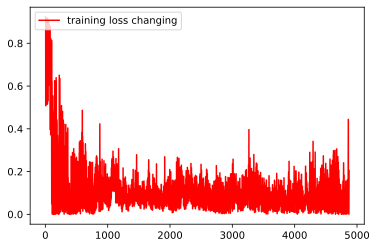

In [9]:
depth = 4
width = 150 * 6
config = {
    'embeddingSize': 110,
    'CIN_depth':depth,
    'DNN_depth':depth,
    'DNN_layer_width':width,
    'Autoint_depth':depth,
    'Autoint_head_num':8,
    'Autoint_att_embedding_size':180,
    'parallel_parts':3,
    'epoch':8,
    'optimizer': 'Adam',
    'loss': 'binary_crossentropy',
    'lr':1e-5,
    'batchRatio':0.8,#0.0005,
    'priceNormalizeCoefficient': 0.001,
    'input_feature_value_threshold':0.0,
    'predict_possibilty_threshold':0.0,
    'saveModelPath': './',
    'train_data_file_path': "./real_ctr_data/ctr_train.csv",
    'test_data_file_path': "./real_ctr_data/ctr_test.csv",
    'validation_data_file_path':"./real_ctr_data/ctr_validation.csv",
}

model = XDeepFM(config)
model.train(saveModel=False)


prediction: 0.0397
  log_loss: 0.0405
     label: 0.0
prediction: 0.2
  log_loss: 0.2231
     label: 0.0
prediction: 0.1252
  log_loss: 0.1338
     label: 0.0
prediction: 0.095
  log_loss: 0.0998
     label: 0.0
prediction: 0.0493
  log_loss: 0.0505
     label: 0.0
prediction: 0.0003
  log_loss: 0.0003
     label: 0.0
prediction: 0.0691
  log_loss: 0.0716
     label: 0.0
prediction: 0.1038
  log_loss: 0.1096
     label: 0.0
prediction: 0.0029
  log_loss: 0.0029
     label: 0.0
prediction: 0.0051
  log_loss: 0.0051
     label: 0.0
prediction: 0.1158
  log_loss: 0.1231
     label: 0.0
prediction: 0.0139
  log_loss: 0.014
     label: 0.0
prediction: 0.0914
  log_loss: 0.0959
     label: 0.0
prediction: 0.1462
  log_loss: 0.158
     label: 0.0
prediction: 0.0
  log_loss: 0.0
     label: 0.0
prediction: 0.0159
  log_loss: 0.0161
     label: 0.0
prediction: 0.1231
  log_loss: 0.1314
     label: 0.0
prediction: 0.0127
  log_loss: 0.0128
     label: 0.0
prediction: 0.1742
  log_loss: 0.1914
 

==AUC: 0.888
 fpr: [0.         0.         0.         0.02083333 0.02083333 0.04166667
 0.04166667 0.14583333 0.14583333 0.28125    0.28125    0.36458333
 0.36458333 1.        ] 
 tpr: [0.    0.125 0.25  0.25  0.375 0.375 0.625 0.625 0.75  0.75  0.875 0.875
 1.    1.   ] 
 threshold: [1.42229662e+00 4.22296624e-01 2.87162087e-01 2.24455759e-01
 2.04393377e-01 1.99960330e-01 1.95426076e-01 1.58947634e-01
 1.55754396e-01 1.15814188e-01 1.04185998e-01 9.14216235e-02
 9.11906954e-02 3.04691964e-05]


<Figure size 432x288 with 0 Axes>

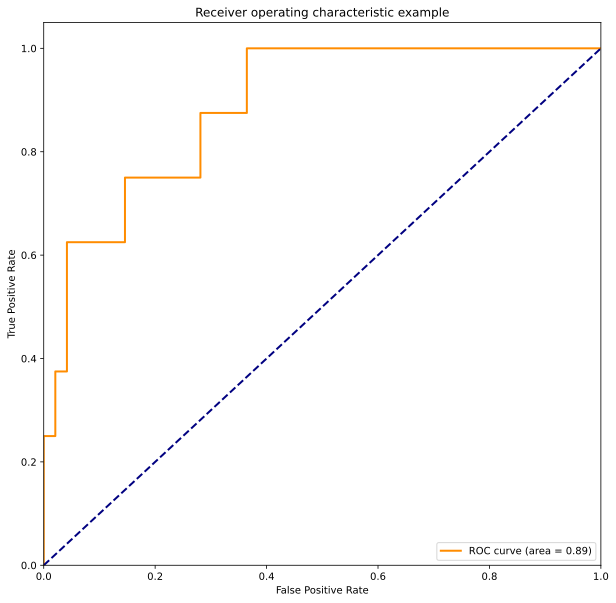

In [8]:
model.evaluate("")